In [ ]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

In [ ]:
# Load international online transactions data from CSV
df = pd.read_csv('/content/int_online_tx.csv')


In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


<Axes: xlabel='count', ylabel='Country'>

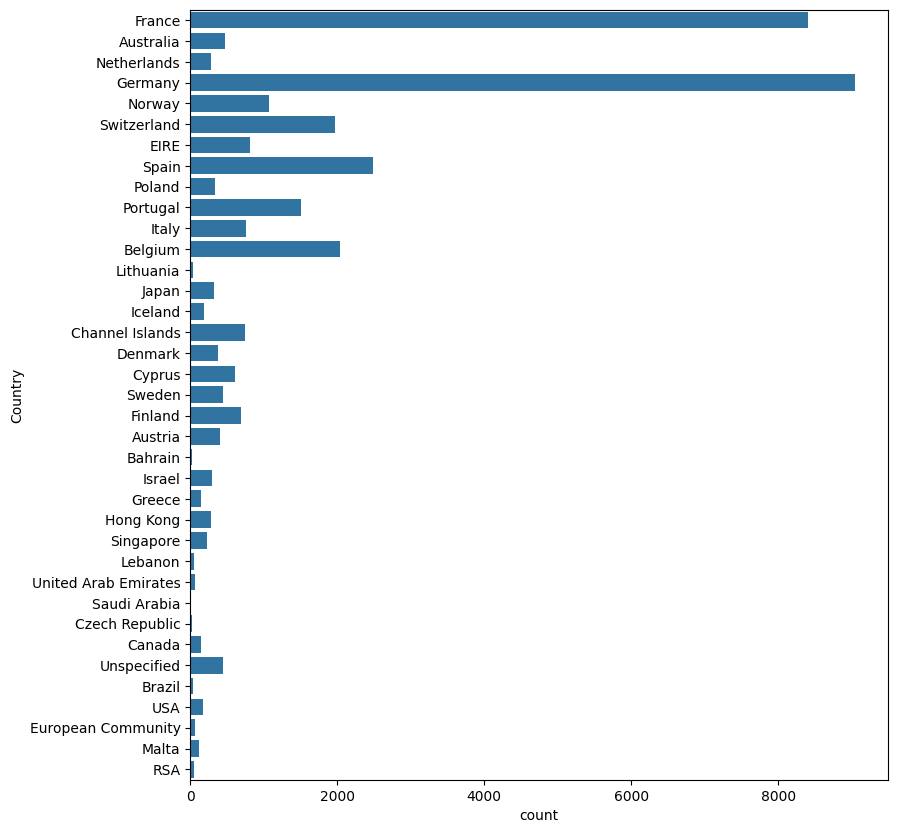

In [ ]:
# Make figsize
plt.figure(figsize=(9,10))

# Bar plot by country
sns.countplot(y='Country', data=df)

Transaction-level Cleaning

In [ ]:
# Missing data by feature
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,1418
Country,0


In [ ]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

In [ ]:

# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

,CustomerID
0,12583
1,12583
2,12583
3,12583
4,12583


In [ ]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

,Sales
0,90.0
1,90.0
2,45.0
3,10.2
4,15.6


In [ ]:
# Save cleaned transaction-level data
df.to_csv('/content/cleaned_transactions.csv', index=None)

Customer-level feature engineering
Now that we have a cleaned transaction-level dataset, it's time to roll it up (aggregate up) to the customer level, which we'll feed into our machine learning algorithms later.

We want 1 customer per row, and we want the features to represent information such as:

Number of unique purchases by the customer
Average cart value for the customer
Total sales for the customer
Etc.
To do so, we'll use two tools seen already:

groupby() to roll up by customer.
agg() to engineer aggregated features.
Aggegrate invoice data by customer. We'll engineer 1 feature:

'total_transactions' - the total number of unique transactions for each customer.

In [ ]:
# Aggregate invoice data
invoice_data = df.groupby('CustomerID').agg(total_transactions=('InvoiceNo', 'nunique'))

# Display invoice data for the first 5 customers
invoice_data.head()


,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [ ]:
# Aggregate product data
product_data = df.groupby('CustomerID').agg(
    total_products=('StockCode', 'count'),
    total_unique_products=('StockCode', 'nunique')
)

# Display product data for the first 5 customers
product_data.head()


,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


Finally, aggregate sales data by customer. Engineer 2 features:

'total_sales' - the total sales for each customer.
'avg_product_value' - the average value of the products purchased by the customer (not the UnitPrice!).

In [ ]:
# Roll up sales data
sales_data = df.groupby('CustomerID').agg(
    total_sales=('Sales', 'sum'),
    avg_product_value=('Sales', 'mean')
)

# Display sales data for the first 5 customers
sales_data.head()


,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


Intermediary levels
You won't always be able to easily roll up to customer-level directly. Sometimes, it will be easier to create intermediary levels first.

For example, let's say we wanted to calculate the average cart value for each customer.

'avg_product_value' isn't the same thing because it doesn't first group products that were purchased within the same "cart" (i.e. invoice).
Therefore, let's first aggregate cart data at the "cart-level."

We'll group by 'CustomerID' AND by 'InvoiceID'. Remember, we're treating each invoice as a "cart."
Then, we'll calculate 'cart_value' by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
Finally, we'll call .reset_index() to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [ ]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).agg(
    cart_value=('Sales', 'sum')
)

# Display cart data for the first 20 carts
cart_data.head(20)


cart_value
CustomerID InvoiceNo            
12347      537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52
           562032         584.91
           573511        1294.32
           581180         224.82
12348      539318         892.80
           541998         227.44
           548955         367.00
           568172         310.00
12349      577609        1757.55
12350      543037         334.40
12352      544156         296.50
           545323         144.35
           545332         840.30
           546869         120.33
           547390         160.33
           567505         366.25
           568699         266.25

In [ ]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
5,12347,573511,1294.32
6,12347,581180,224.82
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,367.00


Now that we have cart-level cart data, all we need to do is roll up by CustomerID again to get customer-level cart data.

Aggregate cart data by customer. Engineer 3 features:

'avg_cart_value' - average cart value by customer.
'min_cart_value' - minimum cart value by customer.
'max_cart_value' - maximum cart value by customer.

In [ ]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').agg(
    avg_cart_value=('cart_value', 'mean'),
    min_cart_value=('cart_value', 'min'),
    max_cart_value=('cart_value', 'max')
)

# Display cart data for the first 5 customers
agg_cart_data.head()


,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


Joining various customer level dataframes
We have multiple dataframes that each contain customer-level features:

invoice_data
product_data
sales_data
agg_cart_data


In [ ]:
# Join together customer-level data
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


save customer_df as our analytical base table to use later.

Very Important: We will not set index=None because we want to keep the CustomerID's as the index (this will be important and we'll see later).

In [ ]:
# Save analytical base table
customer_df.to_csv('/content/analytical_base_table.csv')

import the cleaned dataset (not the analytical base table) that we saved in previously.

In [ ]:
# Read cleaned_transactions.csv
df = pd.read_csv('/content/cleaned_transactions.csv')

In [ ]:
# Get item_dummies - creates the vector of StockCode
item_dummies = pd.get_dummies(df.StockCode)

item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


add 'CustomerID' to this new dataframe so that we can roll up (aggregate) by customer later.

In [ ]:
# Add CustomerID to item_dummies
item_dummies['CustomerID'] = df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583


roll up the item dummies data into customer-level item data.

In [ ]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


As you can see, even after rolling up to the customer level, most of the values are still 0. That means that most customers are not buying a huge array of different items, which is to be expected.

Finally, let's display the total number times each item was purchased.

In [ ]:
# Total times each item was purchased
item_data.sum()

,0
10002,12
10120,1
10125,13
10133,5
10135,4
...,...
90202D,1
90204,1
C2,6
M,34


In [ ]:
# Save item_data.csv
item_data.to_csv('/content/item_data.csv')

PCA

Let's import the full item data that we saved in the previous module (before applying thresholds)

This time, we'll also pass in the argument index_col=0 to tell Pandas to treat the first column (CustomerID) as the index.

In [ ]:
# Read item_data.csv
item_data = pd.read_csv('/content/item_data.csv', index_col=0)

In [ ]:
#scale item_data, which you imported
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

In [ ]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA()

In [ ]:
# Generate new features
PC_items = pca.transform(item_data_scaled)

# Display first 5 rows
PC_items[:5]

array([[ 5.87614052e+00,  4.82891689e+00,  4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05,  6.36694343e-15],
       [-4.21983747e+00,  1.22621722e+00,  1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04,  3.28000300e-15],
       [-1.26084676e+00,  2.38766371e+00,  7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  3.36934126e-15],
       [-4.92931983e+00, -7.14858724e-01,  1.58093026e+00, ...,
        -1.98603886e-03,  9.92316312e-05,  4.68079221e-15],
       [-2.05311348e+00,  2.11095022e+00, -1.84807021e-01, ...,
        -3.43415269e-04, -1.32981672e-04,  9.12972820e-16]])

Explained Variance

It's very helpful to calculate and plot the cumulative explained variance.

This will tell us the total amount of variance we'd capture if we kept up to the n-th component.
First, we'll use np.cumsum() to calculate the cumulative explained variance.
Then, we'll plot it so we can see how many PC features we'd need to keep in order to capture most of the original variance.

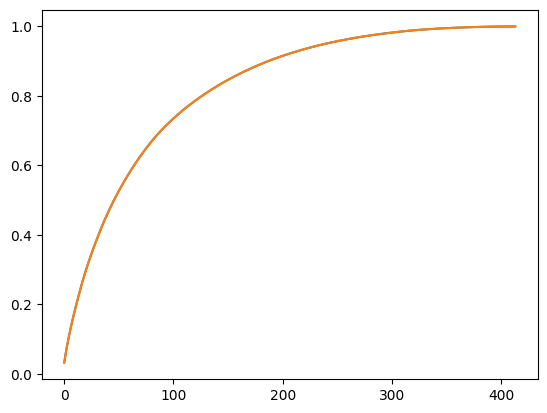

In [ ]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [ ]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[300]

0.9824241831916605

In [ ]:
#Reducing 2574 features down to 300
pca = PCA(n_components=300)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 300)

In [ ]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876141,4.828917,0.495545,3.093849,-0.633706,11.534092,2.161996,7.116957,5.336009,4.424414,-4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464059,-10.603071,1.239909,3.086324,5.336238,-0.410776,-1.616712,6.383660,3.065176,...,-0.081343,0.432419,0.234237,-0.047186,0.101014,0.274877,-0.184920,0.170620,-0.186006,0.103325,0.194960,-0.096132,-0.102909,-0.208161,-0.167860,0.137495,0.057057,-0.028089,0.145896,-0.231022,-0.187444,-0.009110,0.155627,-0.033464,-0.059261,0.028835,-0.071338,-0.016126,-0.049519,-0.016806,0.092598,0.098974,-0.108516,-0.190448,-0.042750,0.004855,0.039971,0.048393,-0.002407,0.123116,-0.161397,0.008598,-0.027122,0.062945,0.003633,0.061758,-0.077207,0.065476,-0.058555,0.072164
12348,-4.219837,1.226217,1.881912,-0.174340,0.817996,-1.160834,-0.871683,-0.846634,0.460240,0.854274,0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185790,0.054586,0.499987,0.373514,1.226615,-0.773073,-0.270125,0.850015,-0.370482,-0.573939,1.012802,-0.580829,0.949802,-0.733970,0.353890,-0.387479,-0.298542,0.396418,0.154925,0.333480,-0.466261,0.703453,-1.200581,-0.202163,-0.871794,-0.055067,-0.421732,1.623014,0.397688,0.452590,...,-0.130990,-0.912092,0.309399,-1.186157,0.668782,-0.999484,-0.458129,0.382676,0.644618,0.434261,1.479497,-1.162202,0.987825,-0.598459,0.155970,1.264833,0.368633,0.628778,-0.167996,-0.006241,0.554608,0.148340,-0.974836,0.107520,-1.182827,0.548454,0.901430,0.735944,0.638664,0.343492,-0.469202,0.198901,0.311394,0.247314,0.006899,0.260979,-0.236935,-0.702549,-0.833925,-0.261172,-0.104526,0.548622,-0.578660,0.876869,-0.456091,-0.097248,-1.274511,0.558779,-0.315195,0.140487
12349,-1.260847,2.387664,0.073148,-1.119161,-0.034339,3.715390,-0.343602,-0.149045,-0.790001,-0.379234,-1.570090,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098817,-0.929870,0.090829,-0.095242,0.163216,0.700639,1.381549,-0.243736,-0.105134,0.176474,-0.862918,1.685211,...,0.602368,-0.146729,0.244455,-0.499909,0.843225,0.421506,0.702527,-0.103167,1.029380,0.635347,0.257802,-0.232147,0.395038,0.374628,0.067921,-0.519914,-0.241072,0.758969,0.446554,-0.065629,0.058881,0.295333,0.068973,0.103796,0.123376,0.107368,0.195143,0.043587,-0.107122,0.640237,-0.077144,-0.241402,-0.340387,-0.520869,-0.029076,-0.363158,-0.070807,0.828818,0.286308,0.021908,-0.362386,0.329908,-0.052749,-0.157278,0.599564,0.235059,-0.531787,-0.351096,-0.293049,-0.665578
12350,-4.929320,-0.714859,1.580930,-0.469767,-0.116290,-0.647835,0.112905,-1.336313,1.547069,-1.190409,0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903530,1.364748,0.178124,-0.260398,-0.168825,-0.681952,1.081305,-0.155238,-0.397164,0.240050,0.634067,-1.447081,-0.186097,-0.315379,-0.306429,-1.359020,-0.001474,0.579056,-0.248313,0.588130,-0.217986,-0.284602,0.525266,-0.531672,-0.101393,-1.47

In [ ]:
# Save pca_item_data.csv
items_pca.to_csv('/content/pca_item_data.csv')

KMeans Clustering

Let's import 2 CSV files we've saved throughout this project.

Let's import 'analytical_base_table.csv' as base_df.


Let's import 'pca_item_data.csv' as pca_item_data.

Set index_col=0 for each one to use CustomerID as the index.

In [ ]:
# Import analytical base table
base_df = pd.read_csv('/content/analytical_base_table.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('/content/pca_item_data.csv', index_col=0)


In [ ]:
# Print shape of each dataframe
print( base_df.shape )
print( pca_item_data.shape )

(414, 8)
(414, 300)


In [ ]:
#Create a pca_df by joining base_df with pca_item_data.
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828917,0.495545,3.093849,-0.633706,11.534092,2.161996,7.116957,5.336009,4.424414,-4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464059,...,-0.081343,0.432419,0.234237,-0.047186,0.101014,0.274877,-0.184920,0.170620,-0.186006,0.103325,0.194960,-0.096132,-0.102909,-0.208161,-0.167860,0.137495,0.057057,-0.028089,0.145896,-0.231022,-0.187444,-0.009110,0.155627,-0.033464,-0.059261,0.028835,-0.071338,-0.016126,-0.049519,-0.016806,0.092598,0.098974,-0.108516,-0.190448,-0.042750,0.004855,0.039971,0.048393,-0.002407,0.123116,-0.161397,0.008598,-0.027122,0.062945,0.003633,0.061758,-0.077207,0.065476,-0.058555,0.072164
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226217,1.881912,-0.174340,0.817996,-1.160834,-0.871683,-0.846634,0.460240,0.854274,0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185790,0.054586,0.499987,0.373514,1.226615,-0.773073,-0.270125,0.850015,-0.370482,-0.573939,1.012802,-0.580829,0.949802,-0.733970,0.353890,-0.387479,-0.298542,0.396418,0.154925,0.333480,-0.466261,0.703453,...,-0.130990,-0.912092,0.309399,-1.186157,0.668782,-0.999484,-0.458129,0.382676,0.644618,0.434261,1.479497,-1.162202,0.987825,-0.598459,0.155970,1.264833,0.368633,0.628778,-0.167996,-0.006241,0.554608,0.148340,-0.974836,0.107520,-1.182827,0.548454,0.901430,0.735944,0.638664,0.343492,-0.469202,0.198901,0.311394,0.247314,0.006899,0.260979,-0.236935,-0.702549,-0.833925,-0.261172,-0.104526,0.548622,-0.578660,0.876869,-0.456091,-0.097248,-1.274511,0.558779,-0.315195,0.140487
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260847,2.387664,0.073148,-1.119161,-0.034339,3.715390,-0.343602,-0.149045,-0.790001,-0.379234,-1.570090,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098817,-0.929870,0.090829,-0.095242,...,0.602368,-0.146729,0.244455,-0.499909,0.843225,0.421506,0.702527,-0.103167,1.029380,0.635347,0.257802,-0.232147,0.395038,0.374628,0.067921,-0.519914,-0.241072,0.758969,0.446554,-0.065629,0.058881,0.295333,0.068973,0.103796,0.123376,0.107368,0.195143,0.043587,-0.107122,0.640237,-0.077144,-0.241402,-0.340387,-0.520869,-0.029076,-0.363158,-0.070807,0.828818,0.286308,0.021908,-0.362386,0.329908,-0.052749,-0.157278,0.599564,0.235059,-0.531787,-0.351096,-0.293049,-0.665578
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929320,-0.714859,1.580930,-0.469767,-0.116290,-0.647835,0.112905,-1.336313,1.547069,-1.190409,0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903530,1.364748,0.178124,-0.260398,-0.168825,-0.681952,1.081305,-0.155238,-0.397164,0.240050,0.634067,-1.447081,-0.186097,-0.315379,-0.306429,-1.359020,-0.001474,0.579056,-

In [ ]:
#First scale both the dataframes

# Initialize instance of StandardScaler
p_scaler = StandardScaler()

# Fit and transform

pca_df_scaled = p_scaler.fit_transform(pca_df)

K-Means with pca_df

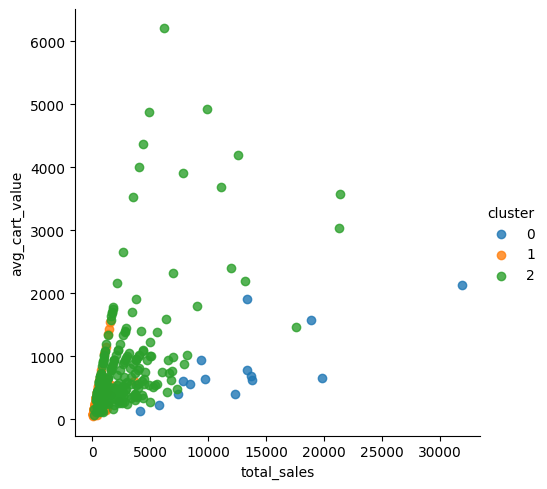

In [ ]:
p_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)
p_kmeans.fit(pca_df_scaled)

pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

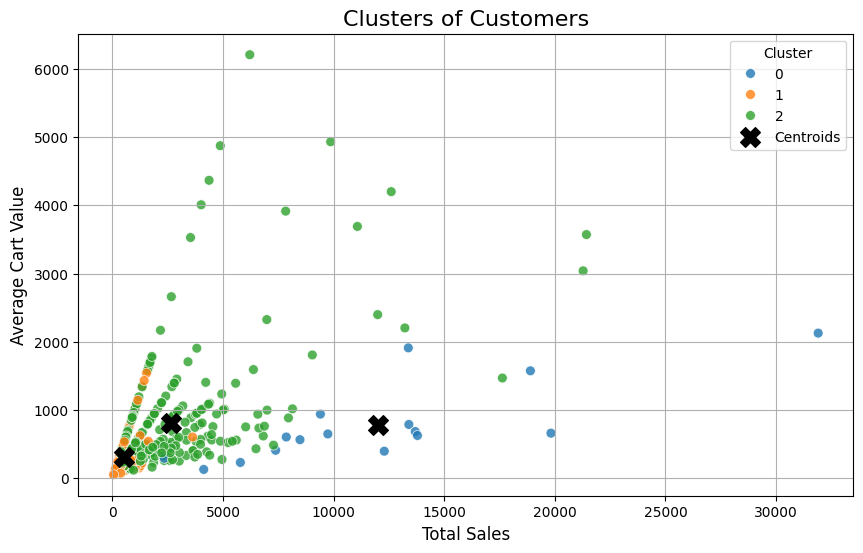

In [ ]:

# Retrieve cluster centers and inverse transform
centroids_scaled = p_kmeans.cluster_centers_
centroids = p_scaler.inverse_transform(centroids_scaled)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='total_sales',
    y='avg_cart_value',
    hue='cluster',
    palette='tab10',
    data=pca_df,
    s=50,
    alpha=0.8
)

# Plot cluster centroids
plt.scatter(
    centroids[:, pca_df.columns.get_loc('total_sales')],
    centroids[:, pca_df.columns.get_loc('avg_cart_value')],
    s=200,
    c='black',
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('Clusters of Customers', fontsize=16)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('Average Cart Value', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()